In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
train = pd.read_csv('train.csv', index_col=0)

In [4]:
test = pd.read_csv('test.csv', index_col=0)

In [5]:
train['isTrain'] = True
test['isTrain'] = False

In [6]:
X = train.append(test, sort=False)

In [7]:
X.describe().T

count         mean          std        min          25%          50%          75%          max
id         8765.0  4404.586366  2542.532548   1.000000  2207.000000  4403.000000  6603.000000  8811.000000
atm_group  8765.0  4407.008842  2427.934099  32.000000  1942.000000  5478.000000  5478.000000  8083.000000
lat        8345.0    54.138304     4.329293  42.057080    52.243997    55.060936    56.116673    69.495093
long       8345.0    63.500873    32.787366  19.941530    37.851107    49.071694    84.950218   173.706490
target     6261.0     0.000715     0.085852  -0.145001    -0.061176    -0.015573     0.040149     0.218608

In [8]:
X.describe(include='object').T

count unique                                                top freq
address      8765   7481             HOROSHEVSKOE SH,V38       MOSKVA          7
address_rus  8345   6147  квартал В-13, городской округ Волгодонск, Рост...   10

### Количество банкоматов стоящих по одному адресу

In [9]:
counts = X.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'count'})

In [10]:
X = pd.merge(X, counts, how='left', on='address_rus')

In [11]:
X.head()

id  atm_group                                 address                                        address_rus  ...          long    target  isTrain  count
0  8526.0       32.0  EMELYANOVA,34          Y-SAKHALINSK     улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...  ...    142.738319  0.011500     True    1.0
1  8532.0       32.0  KOMSOMOLSKAYA,259B     Y.SAKHALINSK     Комсомольская улица, 259, Южно-Сахалинск, Саха...  ...    142.753348  0.029710     True    1.0
2  8533.0       32.0  KOMMUN. PR., 32        YUZHNO SAKHAL    Коммунистический проспект, Южно-Сахалинск, Сах...  ...    142.741113  0.009540     True    1.0
3  8684.0       32.0  LENINGRADSKIY PR.,76A  MOSCOW           Ленинградский проспект, 76А, Москва, Россия, 1...  ...     37.515146 -0.094035     True    1.0
4    37.0       32.0  GVARDEYSKAYA PL., 2    NORILSK          Гвардейская площадь, 2, Норильск, Красноярский...  ...     88.211228  0.079277     True    1.0

[5 rows x 9 columns]

### Расстояния до ближайших банкоматов

In [12]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [13]:
knc = KNeighborsClassifier(metric=distance)

In [14]:
dots = X[['lat','long']].dropna()

In [15]:
knc.fit(X=dots , y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7ff3e6a9c730>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [17]:
for i in range(1,6):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [18]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

In [19]:
X = pd.concat([X,dots], axis=1)

### Город размещения

In [20]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 

In [21]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index

In [22]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)

In [23]:
X.city= X.city.rank().fillna(-1)

In [24]:
X_ = X[X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                    'distance_2',  'distance_3',  'distance_4', 'distance_5',
                    'indexes_5', 'mean', 'city']]
Y_ = X.loc[X.isTrain, 'target']

In [25]:
X_

atm_group        lat        lat        long        long  count   ...    distance_3  distance_4  distance_5  indexes_5       mean    city
0          32.0  46.940995  46.940995  142.738319  142.738319    1.0   ...      0.447444    0.461430    0.558967     8335.0   0.409042  5272.0
1          32.0  46.937353  46.937353  142.753348  142.753348    1.0   ...      0.720783    0.721148    0.903549     4770.0   0.647652  5272.0
2          32.0  46.959413  46.959413  142.741113  142.741113    1.0   ...      0.304450    0.339491    0.495823     6738.0   0.316629  6926.5
3          32.0  55.805827  55.805827   37.515146   37.515146    1.0   ...      0.701862    0.701862    0.820951     4767.0   0.647866  2212.5
4          32.0  69.343541  69.343541   88.211228   88.211228    1.0   ...      0.394887    0.610316    0.878445     1013.0   0.490170  3152.5
5          32.0  43.165860  43.165860  131.908212  131.908212    1.0   ...      0.321874    0.321874    0.322592     4415.0   0.273942   493.5
6          32.0  55.716859  55.716859   37.613063   37.613063    1.0   ...      0.859305    0.926298    0.926298     2722.0   0.806350  2212.5
7          32.0  43.117174  43.117174  131.885503  131.885503    1.0   ...      0.088530    0.141586    0.145161     2619.0   0.110467   493.5
8          32.0  55.799765  55.799765   37.116016   37.116016    1.0   ...      6.673520    6.673520    6.673520      690.0   5.613069  2611.5
9         496.5  53.203220  53.203220   44.978826   44.978826    1.0   ...      0.746726    1.159673    1.159673     4519.0   0.866205  3437.0
10        496.5  56.132925  56.132925   40.419184   40.419184    1.0   ...      1.787131    1.973889    2.171861     6526.0   1.751571   578.5
11        496.5  52.718497  52.718497   41.454511   41.454511    1.0   ...      0.652972    0.983917    1.061424     5308.0   0.709836  4259.0
12        496.5  62.033259  62.033259  129.736382  129.736382    1.0   ...      0.107534    0.169836    0.193449     4618.0   0.114144  5351.0
13        496.5  55.577108  55.577108   42.054370   42.054370    1.0   ...      1.088187    1.157618    1.159935     3028.0   0.885975  6926.5
14        496.5  55.180598  55.180598   36.655611   36.655611    1.0   ...      4.751676    7.491913    7.491913     2806.0   4.984459  6926.5
15        496.5  55.027991  55.027991   36.750518   36.750518    1.0   ...     13.260391   13.648133   14.164778     3368.0  13.116604  6926.5
16        496.5  51.048934  51.048934  107.822322  107.822322    1.0   ...     57.149515   84.415850   84.415850     2449.0  55.915186  6926.5
17        496.5  55.086363  55.086363   82.646830   82.646830    1.0   ...     10.526107   12.235219   15.244376     1693.0  11.393255  6926.5
18        496.5  56.029642  56.029642   47.294593   47.294593    1.0   ...      6.699345    6.699345    6.972537     8338.0   5.889307  6926.5
19        496.5  54.151887  54.151887   74.797890   74.797890    1.0   ...     80.947651  100.328151  100.336705     6569.0  73.919100  6926.5
20        496.5  53.070803  53.070803  158.587520  158.587520    2.0   ...      0.506641    1.954479    2.019014     2436.0   0.923250  3589.0
21        496.5  56.637590  56.637590   47.803974   47.803974    1.0   ...      2.443184    2.443184    4.131555     3729.0   2.697216  6926.5
22        496.5  58.605564  58.605564   49.591163   49.591163    1.0   ...      1.129588    1.129588    1.129588     4444.0   0.968095  1370.0
23        496.5  51.784175  51.784175   55.153504   55.153504    1.0   ...      1.020849    1.020849    1.340356     7958.0   0.752952  3359.5
24        496.5  52.023722  52.023722  113.513428  113.513428    1.0   ...      0.383328    0.383328    0.553126     2186.0   0.391485  5186.0
25        496.5  58.594438  58.594438   49.666657   49.666657    1.0   ...      0.903009    0.903009    0.911464     8322.0   0.760420  1370.0
26        496.5  51.235052  51.235052   36.694293   36.694293    1.0   ...     28.986726   29.699541   45.396996     4803.0  32.115736  6926.5
27

In [25]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.25, random_state=1)

In [26]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [27]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's rmse: 0.0792103
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.0745175
[3]	valid_0's rmse: 0.0705317
[4]	valid_0's rmse: 0.0671016
[5]	valid_0's rmse: 0.0641692
[6]	valid_0's rmse: 0.0616998
[7]	valid_0's rmse: 0.0595902
[8]	valid_0's rmse: 0.0575512
[9]	valid_0's rmse: 0.056037
[10]	valid_0's rmse: 0.054788
[11]	valid_0's rmse: 0.0536961
[12]	valid_0's rmse: 0.0526001
[13]	valid_0's rmse: 0.0517706
[14]	valid_0's rmse: 0.0509879
[15]	valid_0's rmse: 0.0504143
[16]	valid_0's rmse: 0.0499533
[17]	valid_0's rmse: 0.0495757
[18]	valid_0's rmse: 0.0491666
[19]	valid_0's rmse: 0.0488564
[20]	valid_0's rmse: 0.0485702
[21]	valid_0's rmse: 0.0483905
[22]	valid_0's rmse: 0.0481961
[23]	valid_0's rmse: 0.0479803
[24]	valid_0's rmse: 0.0478828
[25]	valid_0's rmse: 0.0477505
[26]	valid_0's rmse: 0.047599
[27]	valid_0's rmse: 0.047524
[28]	valid_0's rmse: 0.0474433
[29]	valid_0's rmse: 0.0473823
[30]	valid_0's rmse: 0.0472947
[31]	valid_0's rmse: 0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

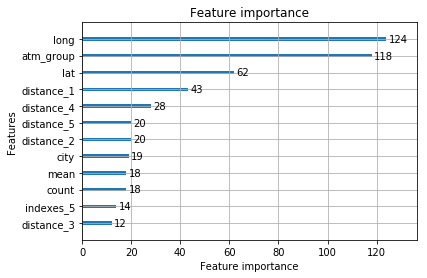

In [28]:
%matplotlib inline
lgb.plot_importance(gbm)

In [29]:
rmse(Y_valid, gbm.predict(X_valid))

0.045904893145415314

In [30]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.08463725683992336

In [31]:
X_test = X[~X.isTrain][['atm_group', 'lat', 'long',  'count', 'distance_1',
                        'distance_2', 'distance_3',  'distance_4', 'distance_5',
                        'indexes_5', 'mean', 'city']]

In [32]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index,columns=['target'])

In [35]:
submit.to_csv('submit.csv')